<ipython-input-1-12a935386ab3>:216: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  curr_edge = np.asscalar(curr_edge) # This is the edge containing
<ipython-input-1-12a935386ab3>:271: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  curr_edge = np.asscalar(curr_edge) # This is the edge containing


'\n'

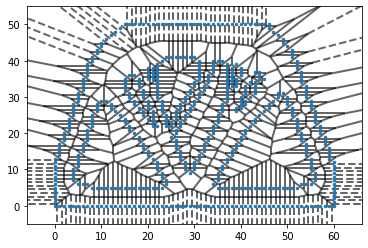

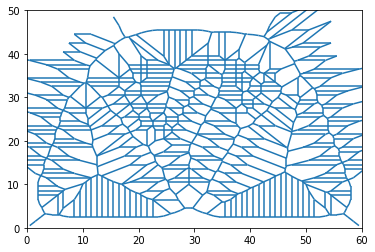

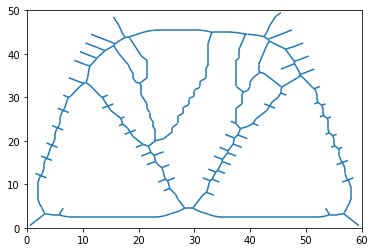

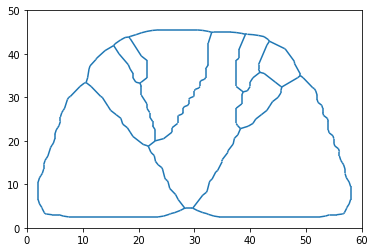

In [1]:
import sys
import scipy
import csv
import numpy as np 
import matplotlib.pyplot as plt
import math    
import visvis as vv

from math import atan, factorial as fac
from skimage import measure
from numpy import sin, cos, sinh, cosh,arcsin,arccos, pi, exp,abs, sqrt
from visvis import Point, Pointset
from scipy.spatial import Voronoi, voronoi_plot_2d, distance
from matplotlib.collections import LineCollection

nelx = 60
nely = 50
thres = 0.5
min_ms = 1 

axes = vv.gca()

def Choose(n,k): 
    return  fac(n)/ fac(k) / fac( n - k )

class nBezier(object):
    def __init__(self, points):
        self.points = np.array(points).astype(np.float32)

    def at(self, t):
        pt = 0 
        n= len(self.points)
        for k in range(n): 
            pt +=  Choose(n-1,k) * (1-t)**(n-1-k) * t**k * self.points[k]
        return pt
    


def BezCurv(list_,pts):
    # Color arrays
    #col_arr = ['g', 'r','b','c','m','y','k'] 
    spec = [6,11,12,13,14]
    # Create list of breps
    brep = [] 
    for i in range(len(list_)):
        array = [] 
        for j in range(len(list_[i])):
            array.append([pts[list_[i][j],0],pts[list_[i][j],1],0])

        # Creating the bezier curve
        Curve  = nBezier(array)

        t = np.linspace(0,1,30) 
        list_of_pts = Pointset(3)
        for  item in t:
            list_of_pts.append(Point(Curve.at(item)))

    
        lines = vv.Line(axes,list_of_pts)# Use matplot lib instead
        lines.lw = 7
        ''' 
        if(i in spec): 
            lines.lc = 'r'
        '''
        
# Open the densities 
densities = []

with open('C:\\Users\\AdminSi\\Desktop\\Masters\\Matlab\\Physics28.csv') as csvfile:
    readCSV = csv.reader(csvfile)
    for row in readCSV:
        for i in row:
            densities.append(float(i))     

# Interpret the indexing 
# Only create boxes when the density is above the threshold  

pixels = np.reshape(densities, (nely, nelx))


# Creating the right 
pts_list = []
count =0  
for i in range(nelx+1):
    for j in range(nely+1):
        pts_list.insert(count,[i,j])
        count = count+1 

# Find which nodes correspond to which element 
elem_nodes = []

count= 0 
for elx in range(nelx):
    for ely in range(nely): 
        n1 = (nely+1)*(elx)+ely 
        n2 = (nely+1)* (elx+1)  +ely
        elem_nodes.insert(count,[elx, ely, n1, n1+1, n2, n2+1])
        count=count+1 

elem_nodes = np.array(elem_nodes)
X = elem_nodes[:,2:6]  

count = 0 

pts_list = np.array(pts_list)

contour_pts = [] 
pts_list[:,1] = nely-pts_list[:,1]


for i in range(len(pts_list)):
    # Find all the elements which have point i 
    idx = np.where(X == i)[0] 
    # Find densities of those elements        
    px = pixels[elem_nodes[idx,1], elem_nodes[idx,0]]
    dens_ls = px[px>thres]
    if(len(dens_ls) != 0 and len(dens_ls)<=2):       
        contour_pts.insert(count,i)  
        count = count+1  

side = np.zeros((len(contour_pts),1))

# Change all the points 

''' 
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(pts_list[contour_pts,0], pts_list[contour_pts,1], color='r')
plt.show()

fig.savefig('TOS1_contour.png') 
'''



# Create Voronoi Diagram  
vor = Voronoi(pts_list[contour_pts,:])

edges  = np.array(vor.ridge_vertices)
pts = vor.vertices 

fig = voronoi_plot_2d(vor,show_vertices=False, line_width=2, line_alpha=0.6, point_size=5)

#fig.savefig('vorContour.png') 
 
# From voronoi to medial axis  
edges = edges[np.all(edges != -1, axis=1)]

lc = LineCollection(pts[edges])
fig = plt.figure()
plt.gca().add_collection(lc)
plt.xlim(0, nelx)
plt.ylim(0, nely)

#fig.savefig('medialaxis.png')


for i in range(len(pts)):  
    x = math.floor(pts[i,0]) 
    y = math.floor(pts[i,1])
    # Remove points outside domain 
    if(x<0 or x>=nelx or y<0 or y>=nely): 
        # Find the edge that has the point 
        edges = edges[np.all(edges !=i, axis=1)]
    else: 
        curr_px = pixels[nely-y-1,x]
        if curr_px < thres :
            edges = edges[np.all(edges !=i, axis=1)] 


# Find degree of all points 
dgree = []   
for i in range(len(pts)): 
    dgree.insert(i, np.count_nonzero(edges ==i ))


    
lc = LineCollection(pts[edges])
fig = plt.figure()
plt.gca().add_collection(lc)
plt.xlim(0, nelx)
plt.ylim(0, nely)

#fig.savefig('beforehair.png')

  
# Remove \"hairs\" from the medial axis 

for i in range(len(pts)): # i is the coordinate of the point to add
    if dgree[i] == 1: # Only selects points with degree one (leaves)
        o=0  # the degree of the target point 
        target=i # current or next point 
        edge_pts = []  
        edge_pts.insert(0,i )
        count_ep = 1 
        ms =0 
        soli_pts = [] 
        count_sp = 0 
        while (o<3):  #or if there are no more edges

            # Not sure what the next 2 are for
            soli_pts.insert(count_sp, i) 
            count_sp = count_sp+1 

            # Finds the index of the point in the edges list
            idx  = np.array(np.where(edges==target)[0])

            # Check if there are other 
            if len(idx)<1: 
                break 

            curr_edge = edges[idx[0],:] # This is the edge containing the point 

            target_index = np.where(curr_edge==target)  # Find the index of the current point 
            curr_edge  = np.delete(curr_edge, target_index) # Delete the current point in the smalle 
            curr_edge = np.asscalar(curr_edge) # This is the edge containing 

            edges  = np.delete(edges,idx[0],axis = 0) # Delete the edge from the edge list

            target = curr_edge # Find the target  
            o=dgree[target] # Define the new starting point by its index
            edge_pts.insert(count_ep,target) 
            count_ep = count_ep+1 

            # Find a way to open the last one
            ms = ms+1 

            #if ms> min_ms: # control the size of the hair which is removed 
                # only remove edges at the end 
            #   break  

# Update degree list
dgree = []   
for i in range(len(pts)): 
    dgree.insert(i, np.count_nonzero(edges ==i ))

edge_pts_cell = [] 
j=0

lc = LineCollection(pts[edges])
fig = plt.figure()
plt.gca().add_collection(lc)
plt.xlim(0, nelx)
plt.ylim(0, nely)



#fig.savefig('casestudy.png')


while(len(edges)>0): 
    for i in range(len(pts)): # i is the coordinate of the point to add
        # edge_pts = [] 
        if (dgree[i]==3):
            o=0 
            target=i # Point index
            edge_pts = []  
            edge_pts.insert(0,i)
            while (o<3): # or if there are no more edges
                # Finds the index of the point in the edges list
                idx  = np.array(np.where(edges==target)[0])

                # Check if there are other 
                if len(idx)<1: 
                    break 

                curr_edge = edges[idx[0],:] # This is the edge containing the point 

                target_index = np.where(curr_edge==target)  # Find the index of the current point 
                curr_edge  = np.delete(curr_edge, target_index) # Delete the current point in the smalle 
                curr_edge = np.asscalar(curr_edge) # This is the edge containing 

                edges  = np.delete(edges,idx[0],axis = 0) # Delete the edge from the edge list                   
                target = curr_edge # Find the target  
                o=dgree[target] # Define the new starting point by its index
                edge_pts.insert(count_ep,target) 
                count_ep = count_ep+1 # Find a way to open the last one 

            if len(edge_pts) >1:
                edge_pts_cell.append(edge_pts)
            j=j+1




BezCurv(edge_pts_cell,pts)


app = vv.use()
app.Run()
'''
'''

In [32]:
# Show an edge once at a time 

#BezCurv(edge_pts_cell,pts)
print(edge_pts_cell[14])




[176, 178, 179, 180, 169, 266, 304, 305, 303, 298, 295, 272, 273]


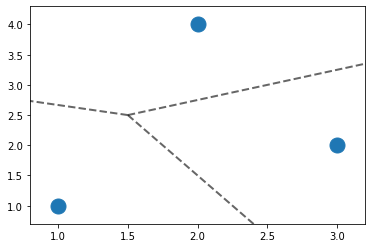

In [108]:
pts_try = [[1,1],[2,4],[3,2]]

vor = Voronoi(pts_try)

edges  = np.array(vor.ridge_vertices)
pts = vor.vertices 


fig = voronoi_plot_2d(vor, show_vertices=False,line_width=2, line_alpha=0.6, point_size=30)
''' 
lc = LineCollection(pts[edges])
fig = plt.figure()
plt.gca().add_collection(lc)
plt.xlim(pts[:,0].min(), pts[:,0].max())
plt.ylim(pts[:,1].min(), pts[:,1].max())
plt.plot(pts[:,0], pts[:,1], 'ro')

#fig.savefig('voronoi.png')
'''


0.2
0.5840761842019654
0.2
0.5257842425520116
0.2
0.24462688002491179
0.3099513680807936
0.4670663665448323
0.2
0.4489754963668763
0.2
0.7416666666666667
0.49661812972956204
0.2
0.2
0.3012856691604127
0.4218099656652871
0.2
0.2
0.2
0.2
0.5743968160720498
0.38450351422672746
0.8365891530225076


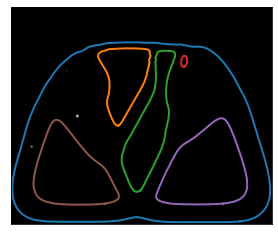

In [53]:
# Find how to obtain the orientation of a strut 
list_ = edge_pts_cell

ang = 50
#r = 2.4
r = 1.7

def dist(a,b):
    return sqrt((b[0]-a[0])**2+(b[1]-a[1])**2)

def Meta_Bez(x,y,list_,pts):
    # Create list of breps
    func = 0
    for i in range(len(list_)):
        # We calculate the coefficient for the r 
        d=0 
        array = [] 
        OA =pi/2- abs(atan((pts[list_[i][-1],1]-pts[list_[i][0],1])/(pts[list_[i][-1],0]-pts[list_[i][0],0])))
        OA = 180*OA/pi 
        for j in range(len(list_[i])):
            array.append([pts[list_[i][j],0],pts[list_[i][j],1]])
            # Calculate the curve's length 
            if(j<len(list_[i])-1):
                d += dist(pts[list_[i][j],:],pts[list_[i][j+1],:] )
        # Creating the bezier curve
        Curve  = nBezier(array)
        if(OA>ang):
            rad = 0.2
            #d= d+20
        #elif(d<10): 
        elif(OA<20): 
            rad = 0.2
        else:
            rad = 0.65/(30**1)*(OA-20)**1+0.2
        n = int(1.7*d)
        print(rad)
        t = np.linspace(0,1,n) 
        for item in t:
            pt = Curve.at(item)
            func += r*(rad)**2/((x-pt[0])**2 +(y-pt[1])**2)**(1.2)
    return func

bot_x = 0;  top_x = nelx; 
bot_y =-5;  top_y = nely; 

x = np.linspace(bot_x,top_x,2*top_x)
y = np.linspace(bot_y,top_y,2*top_y)

X, Y =  np.meshgrid(x, y)

vol = Meta_Bez(X,Y,list_,pts)

# Find contours at a constant value of 0.8
contours = measure.find_contours(vol, 0.5)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(vol, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()
fig.savefig('parttoprint2.png')

In [2]:
pts[:,1] = nely-pts[:,1]

In [7]:
print(np.average(vol))

0.7106365394561344


In [52]:
# EXPORT THE CONTOURs as list of curves
import random

def rhino_script(contour):

    with open('polylines10.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile, delimiter=',', )
        # each collection is associated with a contour level    
        for collection in contour:
            # pline is an autocad command for polyline.  It interprets
            # the next (x,y) pairs as coordinates of a line until
            # it sees a blank line.
            writer.writerows(collection)
            outfile.write('\n')
                    
rhino_script(contours)

In [32]:
# Point of each cell 
def closest_node(node, nodes):
    return np.min(distance.cdist([node], nodes))
pts_dist = []
for i in range(len(pts)):
    pts_dist.append(closest_node(pts[i,:], pts_list[contour_pts]))
    
    

try_list = [i for i in pts_dist if i>150]
print(try_list)
pts_dist = pts_dist / max(pts_dist)


[1662.8717629450564, 267.8479046025935, 1072.8664874997262, 607.8589474540948]


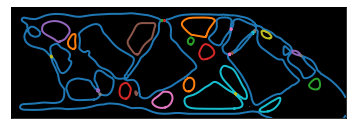

In [37]:
# FInd the real size
list_ = edge_pts_cell

# Points fo each cell 

r = 0.3

def dist(a,b):
    return sqrt((b[0]-a[0])**2+(b[1]-a[1])**2)

def Meta_Bez(x,y,list_,pts):
    # Create list of breps
    func = 0
    tol = 0.2
    for i in range(len(list_)):
        array = []
        d= 0 
        for j in range(len(list_[i])):
            array.append([pts[list_[i][j],0],pts[list_[i][j],1]])
            if(j<len(list_[i])-1):
                d += dist(pts[list_[i][j],:],pts[list_[i][j+1],:] )
        # We calculate the coefficient for the r 
        # Creating the bezier curve
        Curve  = nBezier(array)
        n = int(d)+1
        t = np.linspace(0,1,n) 
        #distance1 = closest_node(pts[list_[i][0],:], pts_list[contour_pts])
        #distance2 = closest_node(pts[list_[i][-1],:], pts_list[contour_pts])
        for  item in t:
            pt = Curve.at(item)
            #distance = item*abs(distance2-distance1)
            distance = closest_node(pt, pts_list[contour_pts])/2
            func +=distance*(r)**2/((x-pt[0])**2 +(y-pt[1])**2)
    return func

bot_x = 0;  top_x = nelx; 
bot_y = 0;  top_y = nely; 

x = np.linspace(bot_x,top_x,4*top_x)
y = np.linspace(bot_y,top_y,4*top_y)

X, Y =  np.meshgrid(x, y)

vol = Meta_Bez(X,Y,list_,pts)

# Find contours at a constant value of 0.8
contours = measure.find_contours(vol, 0.5)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(vol, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()
fig.savefig('result6.png')

In [16]:
print(4%4)

0
